In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
from pathlib import Path
path=Path("/content/drive/MyDrive/Datasets/mask_dataset")
print(path)

/content/drive/MyDrive/Datasets/mask_dataset


In [3]:
csv_path=path/"_classes.csv"
csv_path

PosixPath('/content/drive/MyDrive/Datasets/mask_dataset/_classes.csv')

In [4]:
import pandas as pd

df=pd.read_csv(csv_path)
df.head()

,filename,with_mask,without_mask
0,26-with-mask_jpg.rf.fb2a4fd14461ba4e7d981f51d9...,1,0
1,66_jpg.rf.fb48333563aba0cd06afba343f625d98.jpg,0,1
2,153-with-mask_jpg.rf.fb584ce29ce6d9a3123a04d80...,1,0
3,29-with-mask_jpg.rf.fb9ecac8d3dc335a43b79a9438...,1,0
4,augmented_image_315_jpg.rf.fba9c25c6675c5a039f...,1,0


In [5]:
df.columns  #debugging step as the column name with_mask and without_mask come with a trailing white space

Index(['filename', ' with_mask', ' without_mask'], dtype='object')

In [6]:
df.columns=df.columns.str.strip()

In [7]:
for idx,row in df.iterrows():
  print(row['filename'])
  print(row['with_mask'])
  print(row['without_mask'])
  break

26-with-mask_jpg.rf.fb2a4fd14461ba4e7d981f51d994136b.jpg
1
0


In [8]:
import os
from keras.preprocessing import image
import cv2


!!!!! This cell below took 16 minutes when I run it on my colab using T4 GPU, so be patient as it will load and resize 1279 images in one go

In [9]:
data=[] #an empty list to store [image,label]

for idx,row in df.iterrows():
  img_path=path/str(row['filename'])
  img=cv2.imread(img_path)
  # print("Shape of image before resizing (raw)",img.shape)
  img=cv2.resize(img,(224,224))
  # print("Shape of image after resizing using `cv2.resize` ",img.shape) #this is necessary as often conv nets require images in specific shapes

  label=1 if row['with_mask'] else 0
  # print("label of the current image",label)
  data.append([img,label])
  # print(data)

  # break

print(len(data))

1279


In [10]:
import random   #THIS STEP WORKS MAGICALLY WELL !!!!!!! IT IMPROVES ACCURACY VERY MUCH
random.shuffle(data)

In [11]:
X=[]
y=[]

for features,labels in data:
  X.append(features)
  y.append(labels)

print(X[0])
print(y[0])

[[[ 53  48  63]
  [ 54  49  64]
  [ 55  50  65]
  ...
  [ 23  13  25]
  [ 24  14  26]
  [ 24  14  26]]

 [[ 54  49  64]
  [ 55  50  65]
  [ 56  51  66]
  ...
  [ 23  13  26]
  [ 24  14  26]
  [ 24  14  26]]

 [[ 55  50  65]
  [ 56  51  66]
  [ 56  51  66]
  ...
  [ 24  14  26]
  [ 25  15  27]
  [ 25  15  27]]

 ...

 [[164 161 138]
  [166 164 141]
  [172 170 146]
  ...
  [ 58  48  59]
  [ 59  50  60]
  [ 55  46  56]]

 [[163 161 137]
  [166 164 140]
  [172 170 146]
  ...
  [ 58  48  61]
  [ 58  48  61]
  [ 54  44  57]]

 [[163 161 137]
  [166 164 140]
  [172 170 146]
  ...
  [ 58  48  60]
  [ 58  48  60]
  [ 55  45  57]]]
1


In [12]:
import numpy as np

X=np.array(X)
y=np.array(y)

X.shape, y.shape

((1279, 224, 224, 3), (1279,))

In [13]:
X=X/255.0  #if you run this cell more than once values will get divided by 255 on your every execution of this very cell
np.max(X), np.min(X)

(np.float64(1.0), np.float64(0.0))

In [14]:
print(X.dtype)

float64


In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [16]:
print(f"Shape of training data {X_train.shape} , {y_train.shape}")
print(f"Shape of testing data {X_test.shape} , {y_test.shape}")

Shape of training data (1023, 224, 224, 3) , (1023,)
Shape of testing data (256, 224, 224, 3) , (256,)


In [17]:
from keras.applications.vgg16 import VGG16

vgg=VGG16()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [18]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from keras import Sequential

model=Sequential()

In [20]:
vgg.layers

[<InputLayer name=input_layer, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <MaxPooling2D name=block1_pool, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <MaxPooling2D name=block3_pool, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <MaxPooling2D name=block4_pool, built=True>,
 <Conv2D name=block5_conv1, built=True>,
 <Conv2D name=block5_conv2, built=True>,
 <Conv2D name=block5_conv3, built=True>,
 <MaxPooling2D name=block5_pool, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=fc1, built=True>,
 <Dense name=fc2, built=True>,
 <Dense name=predictions, built=True>]

In [21]:
for layer in vgg.layers[:-1]:  #removing the head of the model for our custom head
  model.add(layer)

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
#freezing the builtin params

for layer in model.layers:
  layer.trainable=False

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 134,260,544 (512.16 MB)

In [24]:
from keras.layers import Dense

model.add(Dense(1,activation='sigmoid'))  #changed the last layer to our custom layer for binary classification

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,264,641 (512.18 MB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

So we have 4097 trainable parameter 4096 coming from the previous layers' neuron connections and one is the bias of our last layer

In [26]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
from tqdm import tqdm #tqdm just gives a attractive progress bar while training

tqdm(model.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test)))

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 666ms/step - accuracy: 0.5540 - loss: 0.7186 - val_accuracy: 0.6289 - val_loss: 0.5410
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.8351 - loss: 0.4259 - val_accuracy: 0.9414 - val_loss: 0.3096
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.9269 - loss: 0.3012 - val_accuracy: 0.9531 - val_loss: 0.2483
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.9261 - loss: 0.2479 - val_accuracy: 0.9648 - val_loss: 0.2072
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.9348 - loss: 0.2387 - val_accuracy: 0.9570 - val_loss: 0.1922


0it [00:00, ?it/s]

In [28]:
# cap=cv2.VideoCapture(0)  #create a videocapture object for reading video from camera, file or live stream

In [29]:
# from google.colab.patches import cv2_imshow

# while True:
#   ret,frame=cap.read()
#   cv2_imshow(frame)

#   if cv2.waitKey(1) & 0xFF == ord('x'):
#     break

# cv2.destroyAllWindows()

#This code doesn't work in colab or virtual environment

In [30]:
def detect_face_mask(img):

  y_pred=model.predict(img.reshape(1,224,224,3))
  return 1 if y_pred>0.7 else 0

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0 ---> Without Mask 🙂


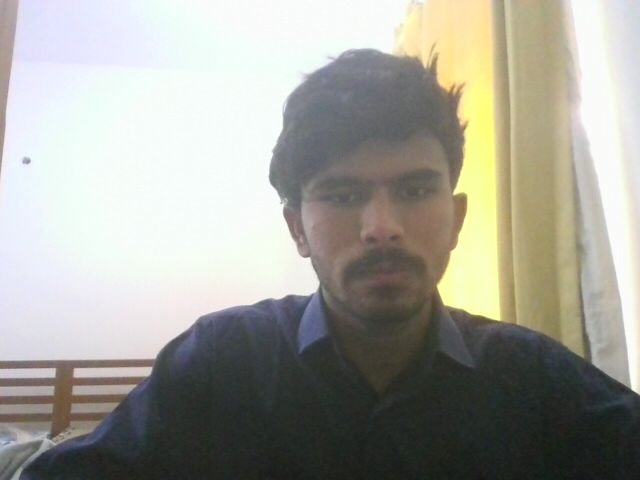

In [35]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from PIL import Image
import io

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize video for notebook display
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture click
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Capture photo
filename = take_photo()

# Load and preprocess image
img = cv2.imread(filename)               # BGR image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB if model trained on RGB
img = cv2.resize(img, (224,224))         # Resize to input size of model
img = img / 255.0                        # Normalize if you trained with normalization

# Predict
y_pred = model.predict(img.reshape(1,224,224,3))

if y_pred > 0.7:
    print("1 ---> With Mask 😷")
else:
    print("0 ---> Without Mask 🙂")

# Show image back
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.imread(filename))



### **1----> with mask**
### **0----> without mask**

In [37]:
sample1=cv2.imread("/content/boy_wearing_face_mask.png")
sample1=cv2.resize(sample1,(224,224))

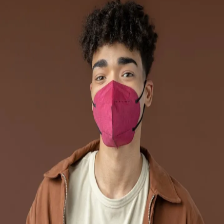

In [39]:
cv2_imshow(sample1)

In [38]:
detect_face_mask(sample1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


1

In [40]:
sample2=cv2.imread("/content/boy_wearing_no_mask.png")
sample2=cv2.resize(sample2,(224,224))

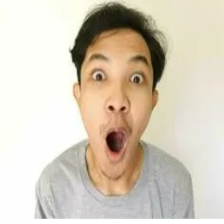

In [41]:
cv2_imshow(sample2)

In [42]:
detect_face_mask(sample2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


0

###After Project View
So this was a fun project to do, not very much challenging but it built my fundamentals for making computer vision projects, like how to load the data, build the architecture and train and evaluate the model and after that use laptop's webcam to do live predictions

In this project I used keras library mainly, aside from that drive module of colab, pathlib to make paths where my dataset and its metadata csv is in my drive, pandas to read the csv which has the info about the filename and label of the image,cv2 to read and resize the images and converting the read images into data (python lists), random for shuffling the data, numpy to convert data into arrays, sklearn for train test split then used VGG16 from keras.applications for employing Transfer learning, froze the head and added my custom head for binary classification, then after that I ran into a problem that cv2.imshow or cv2_imshow didn't work in colab so I have to find some other way out which was I had to use Javascript workaround which connects colab to my webcam to feed frames into python after that I made live prediction using webcam as well as sample images from internet which I had to resize as VGG16 takes (224,224,3) shaped images to make predictions.